# How Does Maximum Entropy Help Exploration in Reinforcement Learning?

The popular [stochastic actor-critic (SAC)](https://arxiv.org/abs/1801.01290) algorithm uses maximum entropy RL to improve exploration in complex continuous domains. The precursor was [soft-Q-learning (SQL)](https://arxiv.org/abs/1702.08165), which uses the same idea, but applies the entropy bonus to the action-value function for use in Q-learning. This post shows you how and why the entropy bonus controls exploration.

## Test Environment

First, I need an environment to demonstrate the differences. There are a few simple grid-world implementations, but none that worked with a discrete action space like I wanted. Using a discrete action space makes the Q-Learning implementation very simple. The main topic of this post is the SQL implementation, so I have removed the environment code from the website rendering. Interested readers can consult the attached notebook.

In [0]:
import gym
from gym import spaces
import random
import numpy as np

class GridWorldEnv(gym.Env):
  """A simple gridworld implementation.

  State: discretized cartesian coordinates
  Actions: discretized compass directions, 45 degree increments.
  Rewards: sparse reward (value 1) to emphasize agent exploration strategy.
  """
  def __init__(self):
    """Feel free to directly edit the values below."""
    self.height = 8 # Height of grid
    self.width = 8 # Width of grid
    self.goal = (7,7) # Goal position
    self.start = (4, 4) # Start position
    
    # Action directions are computed below. Presented in this way so when converted
    # to 3x3 it represents a compass when plotted.
    # This is even more confusing because of the default non-cartesian plotting.
    self.moves = [
            [-1, -1],  # south-west
            [0, -1],  # south
            [+1, -1],  # south-east
            [-1, 0],  # west
            [0, 0],  # stand still
            [+1, 0],  # east
            [-1, +1],  # north-west
            [0, +1],  # north
            [+1, +1],  # north-east
    ]
    self.action_space = spaces.Discrete(len(self.moves))
    self.observation_space = spaces.Discrete(self.height * self.width)
    # self.seed(42)
    self.reset()

  def step(self, action):
    """Take a step in the environment."""
    # Convert discrete action to cartesian coordinates
    change = self.moves[action]
    x, y = self._to_xy(self.S)
    
    # Take move
    x += change[0]
    y += change[1]

    # Check to see if the move attempts to fall off the grid. If so, move
    # it back within bounds.
    x = np.clip(x, 0, self.width - 1)
    y = np.clip(y, 0, self.height - 1)

    # Convert cartesian coordiantes back to discrete
    self.S = self._to_discrete(x, y)
    
    # If at the goal, end and reward
    if self._position_is_goal(x, y):
      return self.S, 1, True, {}

    # Else continue
    return self.S, 0, False, {}

  def reset(self):
    """Move back to the start."""
    self.S = self.start[1] * self.width + self.start[0]
    return self.S

  def render(self, mode=None):
    for y in reversed(range(self.height)):
      print("")
      for x in range(self.width):
        idx = y * self.width + x
        if self.S == idx:
          if self._position_is_goal(x, y):
            print("!", end="") # Success!
          else:
            print("x", end="")
        else:
          if self._position_is_goal(x, y):
            print("O", end="") # Goal
          else:
            print("_", end="")
    return self.S

  def _position_is_goal(self, x, y) -> bool:
    """Helper function to check if the goal has been reached."""
    return x == self.goal[0] and y == self.goal[1]

  def _to_discrete(self, x, y) -> int:
    return y * self.width + x

  def _to_xy(self, S) -> (int, int):
    """Convert current state to cartesian coordinates."""
    return int(S % self.width), int(S / self.width)

  def _cartesian_to_discrete(x, y):
    """Helper function to convert cartesian coordinates to discrete"""
    return self.start[1] * self.width + self.start[0]

  def seed(self, s):
    random.seed(s)
    np.random.seed(s)
    self.action_space.seed(s)

## Basic Q-Learning Implementation

Q-learning is the de facto agent in reinforcement learning. In this post I use it as a baseline, but I also reuse a lot of the boilerplate in other soft implementations.

This is a vanilla tabular implementation with static learning rates, discount factors and where I limit the maximum number of iterations per episode. The policy function and value function is delegated to a function, so I can swap out these parts for other implementations.

This code outputs images of the action-values over time.

In [0]:
from typing import Callable
import numpy as np

def train(env, policy_function: Callable[[], int], value_function: Callable[[], float], n_episodes=1000):
  # Set seeds to make results reproducible
  env.seed(42)

  # Hyperparameters - Fixed for the purposes of this experiment
  alpha = 0.1 # Action-value exponential update rate
  gamma = 0.9 # Discount factor
  max_itr_in_episode = 100 # Max number of iterations in an episode

  # Buffers
  q_values = np.zeros([env.observation_space.n, env.action_space.n])
  n_visits = np.zeros([env.observation_space.n, env.action_space.n])

  # Start episode loop
  for i in range(n_episodes):
    state = env.reset()

    # Start iteraction loop
    for itr in range(max_itr_in_episode):
      # Get next action according to policy
      action = policy_function(q_values[state])

      # Iteract with environment
      next_state, reward, done, info = env.step(action)

      # Predict new action value
      q_hat = reward + gamma * value_function(q_values[next_state])
      
      # Update action-value estimates
      q_values[state, action] += alpha * (q_hat - q_values[state, action])
      
      # Metrics
      n_visits[state, action] += 1

      # Move on to the next state; no point hanging around
      state = next_state

      # Break early if we're done
      if done:
        break

    # Monitoring
    if not i % 100:
      plot_action_values(q_values, env=env, show_directions=False)
      plt.title(f"Q-values - Episode {i}")
      plt.show()
  return q_values, n_visits

To implement vanilla Q-Learning, I create a standard ε-Greedy choice of action, which chooses the action with the highest action value estimate. The state value function is also standard, being the maximum of the action-value function for the given state.

In [0]:
def randargmax(b,**kw):
  """ a random tie-breaking argmax"""
  return np.argmax(np.random.random(b.shape) * (b==b.max()), **kw)

def q_learning_policy(q_values, ε, env) -> int:
  """Standard ε-Greedy maximum Q-learning policy."""
  if np.random.uniform(0, 1) < ε:
    return env.action_space.sample()
  else:
    return randargmax(q_values)

def td_state_value_function(q_values_for_state) -> float:
  """Standard TD state-value function."""
  return np.max(q_values_for_state)

Finally, here is a helper function to generate a full roll-out of the optimal trajectory. This will be used to plot trajectories next.

In [0]:
def optimal_trajectory(env, q_values, policy_function: Callable[[], int] = np.argmax) -> list:
  state = env.reset() # Reset the state
  trajectory = [] # Buffer to hold trajectories
  trajectory.append(state)
  for itr in range(20): # Limit to 20 steps just in case
    action = policy_function(q_values[state]) # Chose action
    state, reward, done, info = env.step(action) # Step
    trajectory.append(state) # Store next state
    if done: # Break if done
      break
  trajectory = [env._to_xy(t) for t in trajectory ] # Convert to cartesian
  return trajectory

## Visualising Tabular Results in RL

The next challenge is how to visualise the results. I found a useful library called [navigation-vis](https://github.com/yrevar/navigation_vis) by [Yagnesh](https://github.com/yrevar). This is a small set of helper functions to plot an image-like grid of values. I will use this to plot q-values, advantages and other things.

Below is a function that make it easier to plot the action values. The code looks complex, as plotting always is. You do not need to understand this code to continue with the notebook.

In [0]:
!pip install navigation-vis==0.7 > /dev/null

from matplotlib import pyplot as plt, cm as cm
import numpy as np
from navigation_vis.Raster import Raster as NavGridView, get_discrete_cmap

def weighted_directions(q_values, env: GridWorldEnv):
  """Calculates the most probable action by weighting directions by action values."""
  return [np.sum(env.moves * (q - np.mean(q))[:, None], axis=0) for q in q_values]

def plot_direction_arrows(directions, ax, env: GridWorldEnv):
  """Plots the most probable actions. This took a lot of hacking to get the arrows in the right place."""
  ax.quiver(
      3 * (np.tile(np.arange(env.width),env.width)) + 1,
      3 * (np.repeat(np.arange(env.height),env.height)) + 1,
      directions[:,0],
      directions[:,1],
      color="w",
      )

def plot_action_values(
    q_values: list, # action-values
    env: GridWorldEnv, # Environment
    ax=None, # Plot axes for custom plot layouts
    show_colour_bar=True, # Show the colour bar
    show_directions=True, # Show the most probable directions
    show_optimal_trajectory=True, # Show optimal trajectory
    ):
  # Create a plot if it doesn't exist
  if ax is None:
    fig, ax = plt.subplots(1,1,figsize=(6,4));

  # Plot the action-values
  p = NavGridView(np.array(q_values).reshape(env.width*env.height,3,3,1), ax=ax).render(
    cmap=cm.gray).grid().ticks()
  p.ax.invert_yaxis() # Convert to cartesian coordinates

  if show_colour_bar:
    plt.colorbar(p.im)
  if show_directions:
    directions = np.array(weighted_directions(np.array(q_values), env))
    plot_direction_arrows(directions, ax, env)
  if show_optimal_trajectory:
    trajectory = optimal_trajectory(env, np.array(q_values))
    p.add_trajectory(np.append(trajectory, np.ones((len(trajectory),1)), axis=1), True, {"lw": 2, "color":"r"})
    

Now I am ready to run the experiment. Every 100 episodes I plot the action-values for the agent, and the optimal trajectory.

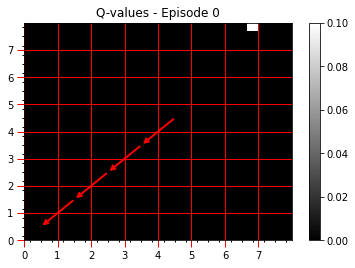

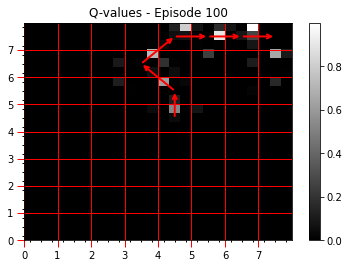

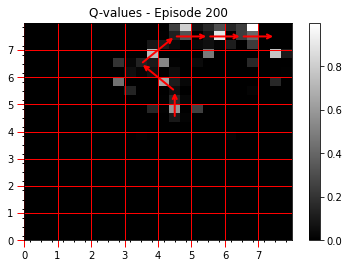

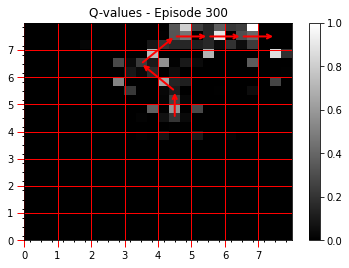

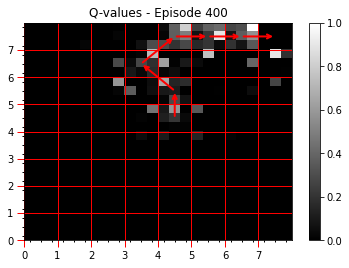

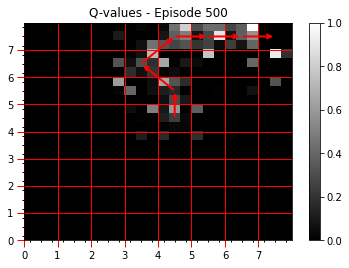

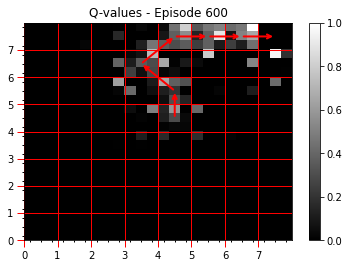

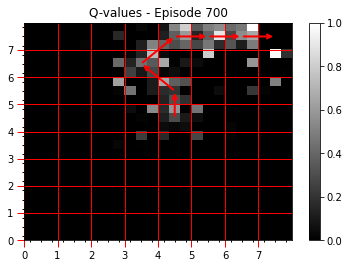

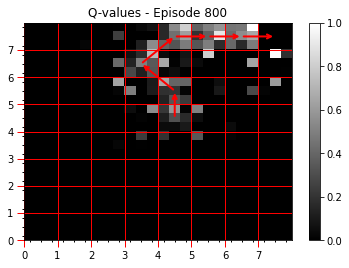

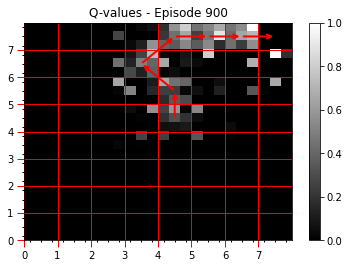

In [0]:
env = GridWorldEnv()
q_learning_q_values, q_learning_n_steps = train(
    env=env,
    policy_function = lambda q_values: q_learning_policy(q_values, ε=0.1, env=env), 
    value_function = td_state_value_function,
  )

Now that we have a trained agent, let's plot the final optimal trajectory.

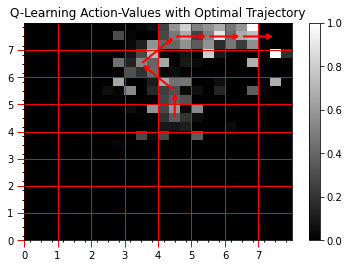

In [0]:
plot_action_values(q_learning_q_values, env=env, show_optimal_trajectory=True, show_directions=False)
plt.title("Q-Learning Action-Values with Optimal Trajectory")
plt.show()

In these plots black represents zero action-values (the default). These locations represent where the agent has not explored. And notice that the optimal trajectory will generate non-optimal paths (depending on the seed). This is because the ε-Greedy exploration hasn't adequately explored all states. To test the robustness of this agent, you can change the start location.

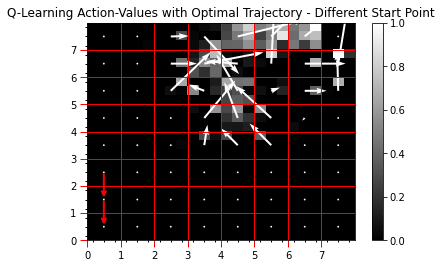

In [0]:
env = GridWorldEnv()
env.start = (0, 2)
plot_action_values(q_learning_q_values, env=env, show_optimal_trajectory=True)
plt.title("Q-Learning Action-Values with Optimal Trajectory - Different Start Point")
plt.show()

When the agent starts in a region of the state space that hasn't been adequately sampled, the agent follows a suboptimal path. You might be able to change the seed and get lucky, but in general results are undefined.

## Crude Probabilistic Q-Learning

One simple, but important improvement is to explore according to a probability distribution that is proportional to the action values. This ensures that it continues to sufficiently sample non-maximal actions, rather than picking the greedy action every time.

You can implement this policy by choosing an action with probabillity proportional the action value, compared to other values. For example, it is common to use a softmax function to convert values into probabilities. This is implemented below.

In [0]:
def clipped_exp(val):
  """Clipped exponential function.
  
  Clipping is important to prevent these equations blowing up under low
  temperatures and high q-values.
  Interested readers: Try removing the clip.
  """
  return np.exp(np.clip(val, -300, 300))

def softmax(q_values, temperature=1):
  """Standard softmax to calculate probabilities."""
  exponents = clipped_exp(q_values / temperature)
  return exponents / np.sum(exponents)

def crude_probabilistic_policy(q_values, env) -> int:
  """A crude probabilistic Q-learning policy."""
  probabilities = softmax(q_values)
  return np.random.choice(np.arange(env.action_space.n), p=probabilities)

The major benefit is the removal of the ε hyper-parameter. Note that other probabilistic measures are available (e.g. UCB, Thompson, etc.).

Let's run this experiment again.

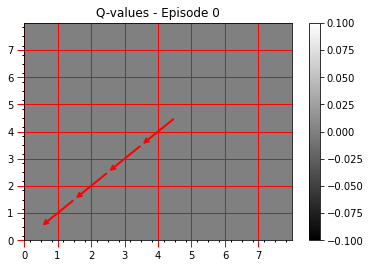

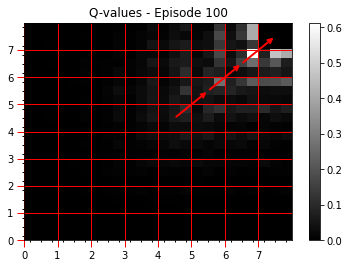

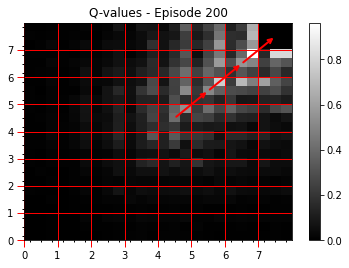

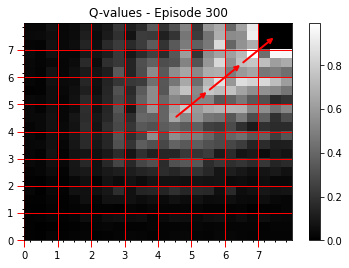

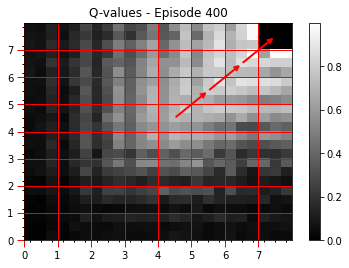

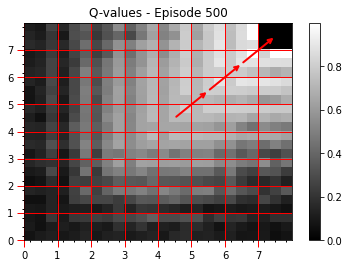

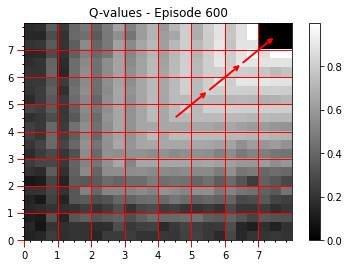

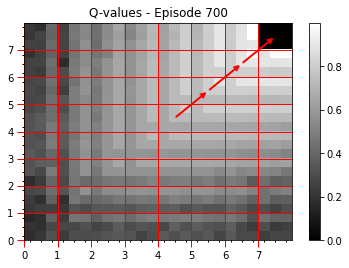

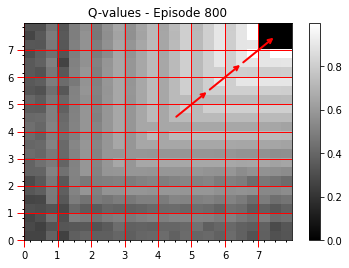

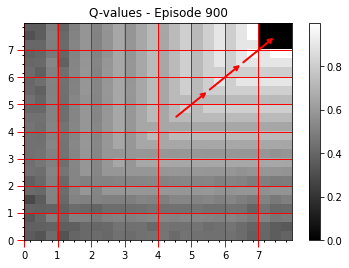

In [0]:
env = GridWorldEnv()
crude_prob_q_values, crude_prob_n_steps = train(
    env=env,
    policy_function = lambda q_values: crude_probabilistic_policy(q_values, env=env), 
    value_function = td_state_value_function,
  )

Now look at those action-values! You can see that the agent has explored all of the state and that there is a good optimal trajectory right from the start. However, note how the action-values appear to grow out of the goal. Exploration isn't random, it is tightly coupled to the reward.

You can plot the directionality of each state by imaging that the actions are the directions on a compass. Then you can define an arrow that has a direction and a magnitude that is proportional to the action values. For example, if the actions are zero everywhere except north, then this will result in a large arrow pointing upwards.

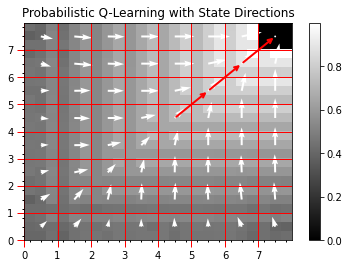

In [0]:
plot_action_values(crude_prob_q_values, env=GridWorldEnv(), show_optimal_trajectory=True, show_directions=True)
plt.title("Probabilistic Q-Learning with State Directions")
plt.show()

Note how all the arrows are pointing towards the optimal trajectory, so no matter where you land, you will end up at the goal. This policy is far more robust than the previous one, all with a single change to the Q-Learning algorithm.

## Soft Q-Learning

Soft Q-Learning adds an entropy term to the objective function, which means you need to optimise to maximise reward _and_ entropy over the actions.

$$
\pi^{*} = \operatorname*{argmax}_{\pi} \text{ } \sum_{t} \mathbb{E} \big[ r(s, a) + \alpha \mathcal{H} (\pi( \cdot \mid s )) \big] \\
$$

You can derive entropy-based value and policy functions from this equation, which I have implemented below. The For more details [consult the original paper](https://arxiv.org/abs/1702.08165).

In [0]:
# SQL Equation (9)
def soft_state_value_function(q_values, temperature):
  return temperature * np.log( np.sum( clipped_exp(q_values / temperature) ) )

# SQL Equation (6) - This is important to provide optimal policies.
# The state appropriately scaled value estimate is also important
# Interested readers: Try swapping it out for `np.mean(q_values)`.
def pi_maxent(q_values, temperature):
  return clipped_exp( (q_values - soft_state_value_function(q_values, temperature)) / temperature)

def sql_policy(q_values, env, temperature):
  pi = pi_maxent(q_values, temperature)
  return crude_probabilistic_policy(pi, env)

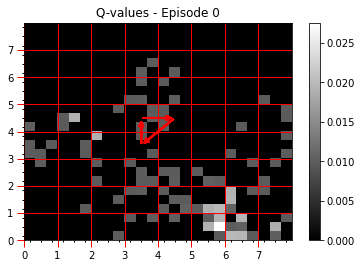

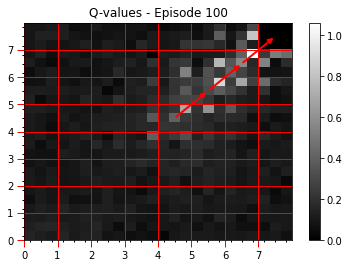

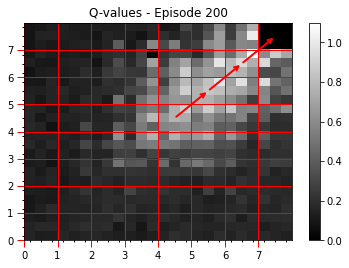

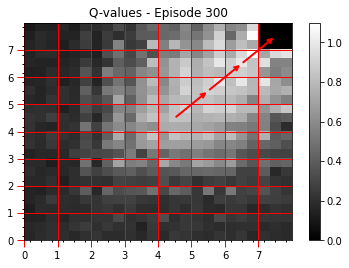

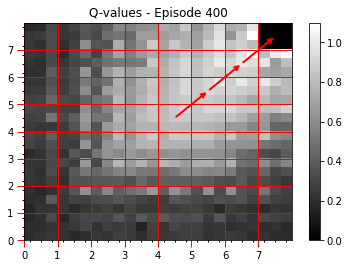

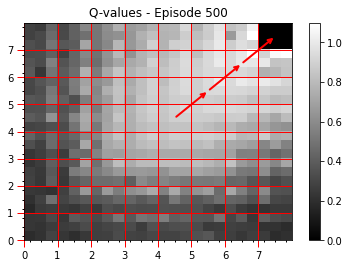

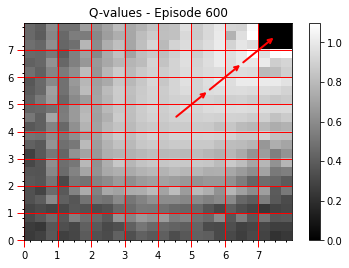

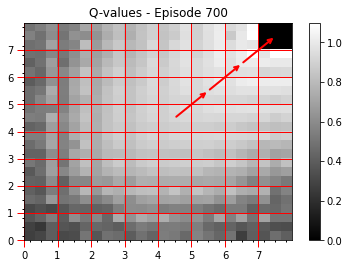

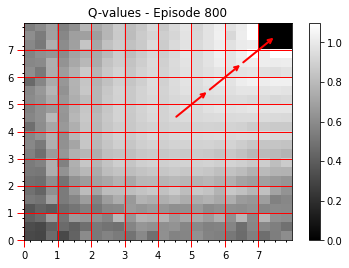

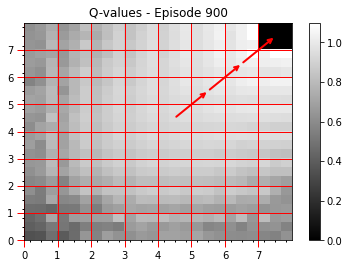

In [0]:
temperature = 0.05 # This value is very important. I manually performed a hyper-parameter search to find this value that works well.
env = GridWorldEnv()
sql_q_values, sql_n_steps = train(
    env=env,
    policy_function = lambda q: sql_policy(q, env=env, temperature=temperature), 
    value_function = lambda q: soft_state_value_function(q, temperature=temperature),
  )

In this simplistic environment, after 1000 episodes, the results appear similar. But to compare the differences, I plot the crude probabilistic Q-Learning approach against SQL below.

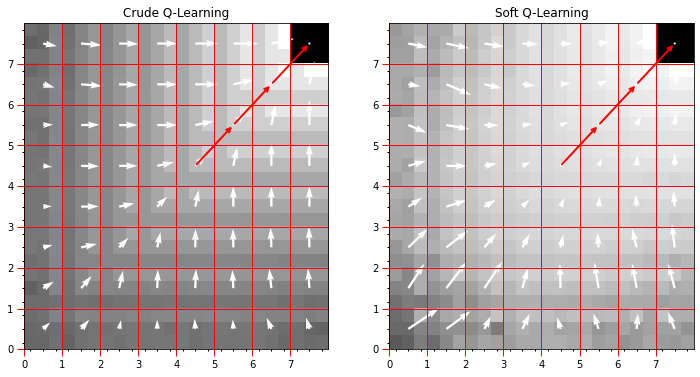

In [0]:
side_by_side_plot = lambda q_values, ax: plot_action_values(q_values, env=env, ax=ax, show_colour_bar=False, show_directions=True, show_optimal_trajectory=True)

fig, ax = plt.subplots(1,2,figsize=(12,6));
side_by_side_plot(crude_prob_q_values, ax[0])
ax[0].set_title("Crude Q-Learning")
side_by_side_plot(sql_q_values, ax[1])
ax[1].set_title("Soft Q-Learning")
plt.show()

The main thing you will notice, if you look carefully, is that the Q-Learning approach has distinct banding, with directions that point to the optimal trajectory. The SQL action-values are more graduated, smoother, which impacts the direction arrows. Look how the magnitude of the arrows are smaller closer to the optimal trajectory, which insinuates that the direction matter less, because the agent will find reach the goal no matter what it does. Further away from the optimal trajectory, the magnitudes are larger, which tells the agent to get a move on. Note that these depend on the temperature hyper-parameter. Try altering the temperature to see what happens.

This subtlety is introduced because the entropy factor overweights actions that are not strictly maximal. Q-Learning shoots for the maximum, every time.

The effects are even more pronouced if you consider a smaller number of episodes. In the experiment below I constrain the number of episodes to 100. The top plot is the usual optimal trajectory plot with directions. The plot below shows the number of times the agent visited a state, where black means it never visited, white means it visited many times.

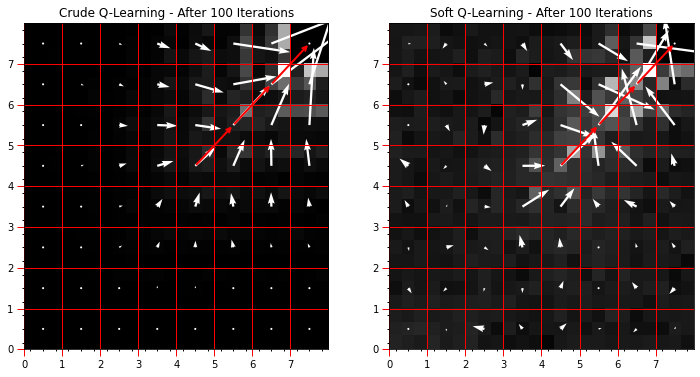

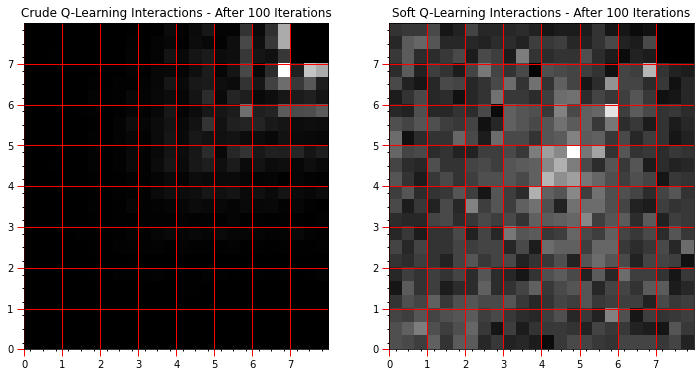

In [0]:
from IPython.display import clear_output

temperature = 0.05
env = GridWorldEnv()
sql_q_values_100, sql_n_steps_100 = train(
    env=env,
    policy_function = lambda q: sql_policy(q, env=env, temperature=temperature), 
    value_function = lambda q: soft_state_value_function(q, temperature=temperature),
    n_episodes = 100
  );

env = GridWorldEnv()
crude_prob_q_values_100, crude_prob_n_steps_100 = train(
    env=env,
    policy_function = lambda q_values: crude_probabilistic_policy(q_values, env=env), 
    value_function = td_state_value_function,
    n_episodes = 100
  );
clear_output()

fig, ax = plt.subplots(1,2,figsize=(12,6));
plot_action_values(crude_prob_q_values_100, env=env, ax=ax[0], show_colour_bar=False)
ax[0].set_title("Crude Q-Learning - After 100 Iterations")
plot_action_values(sql_q_values_100, env=env, ax=ax[1], show_colour_bar=False)
ax[1].set_title("Soft Q-Learning - After 100 Iterations")
plt.show()

fig, ax = plt.subplots(1,2,figsize=(12,6));
plot_action_values(crude_prob_q_values_100, env=env, ax=ax[0], show_colour_bar=False, show_directions=False, show_optimal_trajectory=False)
ax[0].set_title("Crude Q-Learning Interactions - After 100 Iterations")
plot_action_values(sql_n_steps_100, env=env, ax=ax[1], show_colour_bar=False, show_directions=False, show_optimal_trajectory=False)
ax[1].set_title("Soft Q-Learning Interactions - After 100 Iterations")
plt.show()

The optimal policies are unremarkable, even though they generally point in the right direction. But the lower plot, showing the number of times the agent visited a state, is dramatically different. SQL has visited states in a much more uniform manner and visited the extremes of the state space, whereas Q-Learning hasn't bothered.

You can imagine how this extra exploration can help in more complex environments.

## Playing with the Temperature Parameter in SQL

SQL (and SAC) is very dependent on the temperature parameter. It controls the amount of exploration, and if you weight entropy too highly then the agent receives higher rewards for exploration than it does for achieving the goal!

There are two solutions to this problem. The simplest is annealing. By reducing the temperature parameter over time, this forces the agent to explore early on, but become deterministic later. A second, but slightly more complicated approach is to do what the second version of SAC does, automatically learn the temperature parameter. I will leave this for another day. For now, let me show you how temperature affects results.

In the experiment below I increase the temperature value to promote more exploration.

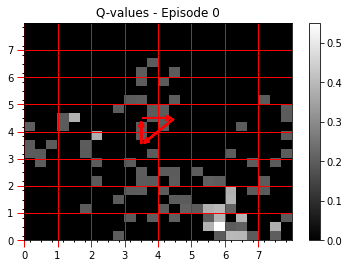

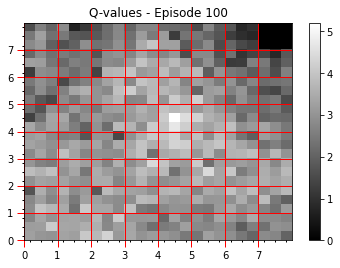

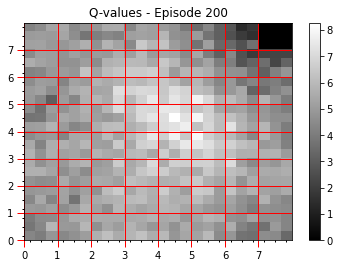

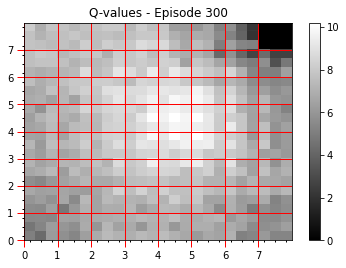

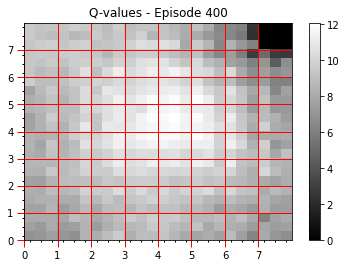

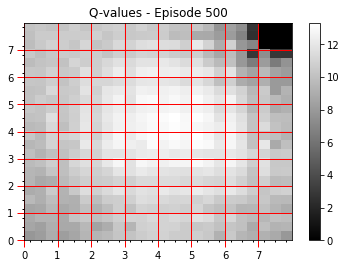

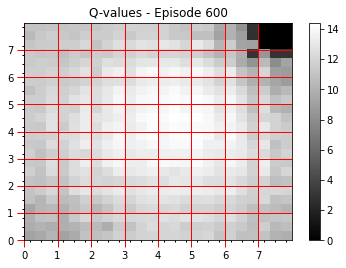

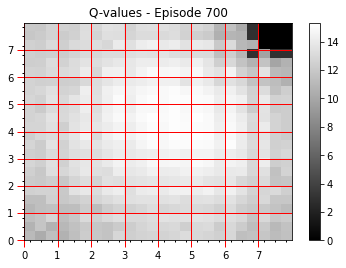

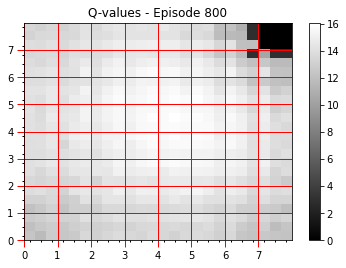

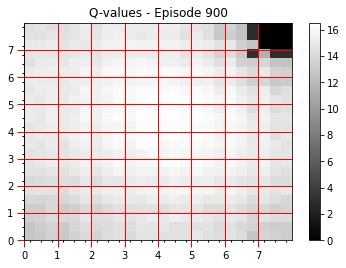

In [0]:
temperature = 1
env = GridWorldEnv()
sql_q_values, sql_n_steps = train(
    env=env,
    policy_function = lambda q: sql_policy(q, env=env, temperature=temperature), 
    value_function = lambda q: soft_state_value_function(q, temperature=temperature),
  )

As you can see from the magnitudes of the action-values, the entropy term is now so large (a maximum of 16) that it overpowers the reward (1). So the optimal policy is to move towards the states with the highest entropy, which are the states in the middle.

Imagine a child in a sweet shop. You could measure sweet anticipation using entropy; more choices mean more enjoyment. In the middle of the shop, the child could move in hundreds of different ways and get a new sweetie. But at the door, right at the edge, there's only a few to choose from. The child would be better to move towards the centre of the shop.

This is exactly what is happening here. Using only entropy as a measure, the middle of the state space is the best place to be.

To combat this, we can reduce the temperature over time to force the child, I mean agent, to do what we want. This is called annealing.

In [0]:
from dataclasses import dataclass
from typing import Callable

@dataclass
class AnnealingTemperature:
  temp: float
  min_temp: float
  rate: float

  def temperature(self) -> float:
    if self.temp > self.min_temp:
      self.temp += self.rate
    return self.temp

def annealing_sql_policy(q_values, env, temperature_func: Callable[[], float]):
  pi = pi_maxent(q_values, temperature_func())
  return crude_probabilistic_policy(pi, env)

def annealing_soft_state_value_function(q_values, temperature_func: Callable[[], float]):
  return temperature_func() * np.log( np.sum( clipped_exp(q_values / temperature_func()) ) )

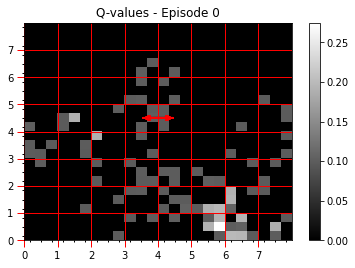

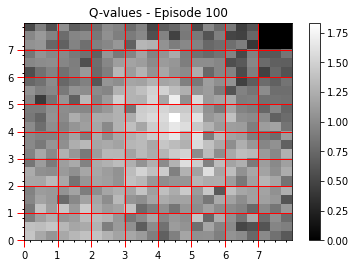

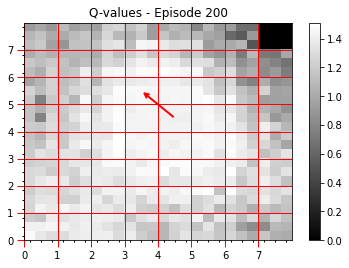

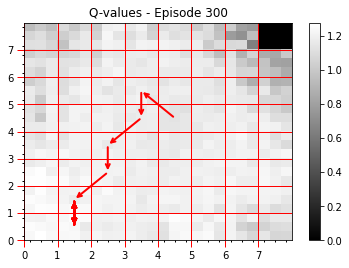

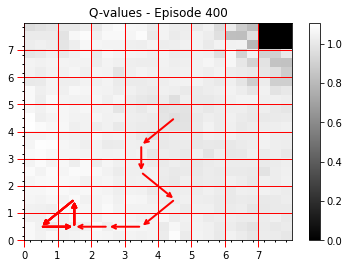

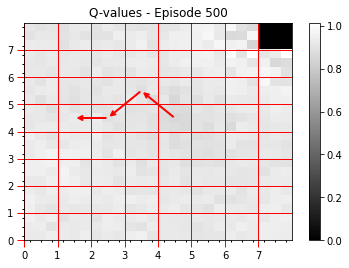

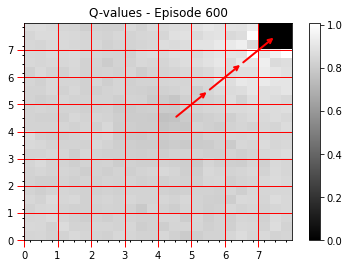

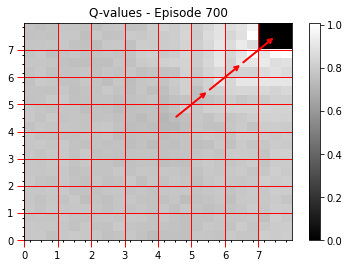

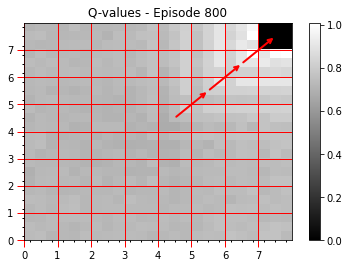

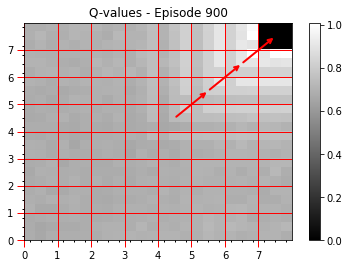

In [0]:
temperature = AnnealingTemperature(temp=0.5, min_temp=0.005, rate=-0.00001)
env = GridWorldEnv()
sql_q_values, sql_n_steps = train(
    env=env,
    policy_function = lambda q: annealing_sql_policy(q, env=env, temperature_func=temperature.temperature), 
    value_function = lambda q: annealing_soft_state_value_function(q, temperature_func=temperature.temperature),
  )

This experiment demonstrates how annealing alters how much the agent explores in early phases of learning. This is extremely useful in complex environments that require large amounts of exploration. Then the change in temperature causes the agent to become more Q-learning-like and hones in on the optimal policy.

Again the starting, stopping and annealing rate parameters are important however. You need to choose these carefully according to your environment and trade off robustness against optimality.

## Summary

Using a bonus that is based upon the entropy of the actions is one way to encourage exploration; there are others. But SAC has shown that entropy methods tend to be particularly good at exploring complex continuous action space. But this post demonstrates that the idea can be applied to simpler algorithms, like Q-Learning, to enhance and control exploration. 